### <span style="color:olive"> Code project - Optimization for Machine Learning - November 2019 </span>

# Detecting Pulsar Stars in the Universe

*Student* : **Louis MONIER**

*Head teacher* : Gabriel Peyré

#### Plan:
#### 0 - Introduction
#### 1 - Testing several supervised ML methods
***

In [4]:
import numpy as np
import pandas as pd
import itertools
from enum import Enum
from IPython.display import Latex
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

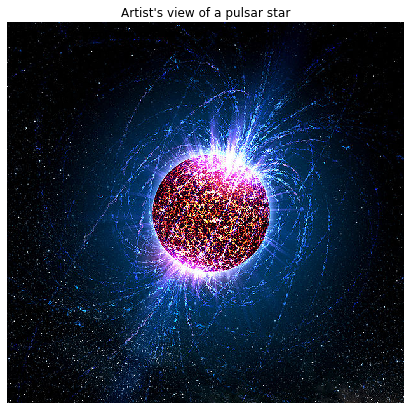

In [1]:

img = np.array(Image.open("Images/pulsar_image.jpg"))
plt.figure(figsize=(8,7))
plt.imshow(img)
plt.title("Artist's view of a pulsar star")
plt.axis("off")
plt.show();

# 0 - Introduction

#### Quick problem overview:

[HTRU2](https://archive.ics.uci.edu/ml/datasets/HTRU2) data set describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (HTRU) survey. Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter. This is why candidates must be classified in to pulsar and non-pulsar classes to aid discovery.

Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. In this lab project, we are going to deal with a **binary classification problem**. Here, the data set contains 16 259 spurious examples caused by noise, and 1 639 real and legitimate pulsar examples. These examples have all been checked by human annotators. 

Each candidate is described by 8 continuous variables, and a single class variable. Each row lists the variables first, and the class label is the final entry. The class labels used are 0 (negative) and 1 (positive).

More details about the data set and its features can be found in the appendix. 

### Load the dataset

In [5]:
data = pd.read_csv(r"pulsar_stars.csv")
data.tail(10) # random sample from the data set

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
17888,98.726562,50.407823,0.565124,0.245231,0.570234,9.011285,22.018589,561.833787,0
17889,126.625000,55.721826,0.002946,-0.303218,0.534281,8.588882,23.913761,660.197035,0
17890,143.671875,45.302647,-0.045769,0.353643,5.173913,26.462345,5.706651,33.802613,0
17891,118.484375,50.608483,-0.029059,-0.027494,0.422241,8.086684,27.446113,830.638550,0
17892,96.000000,44.193113,0.388674,0.281344,1.871237,15.833746,9.634927,104.821623,0
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0
17897,57.062500,85.797340,1.406391,0.089520,188.306020,64.712562,-1.597527,1.429475,0


In [8]:
print("Is there any Nan values in the dataframe?", data.isnull().values.any())

Is there any Nan values in the dataframe? False


### Data preparation

In [4]:
#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
# find non-zero elements
def find(x): return np.nonzero(x)[0]

In [5]:
# extract data and conversion to numpy array
X = data.to_numpy()[:,:-1]
Y = MakeCol(data.to_numpy()[:,-1])

In [6]:
# split into training and testing sets
n = int(0.8*X.shape[0])
m = X.shape[0] - n
d = X.shape[1]
print(n, "samples in training set")
print(m, "samples in test set")
print(d, "features")
print(sum(data.isnull().sum()), "missing values in the data set")

# train set
Xtrain = X[:n]
Ytrain = Y[:n]

# test set
Xtest = X[-m:]
Ytest = Y[-m:]

14318 samples in training set
3580 samples in test set
8 features
0 missing values in the data set


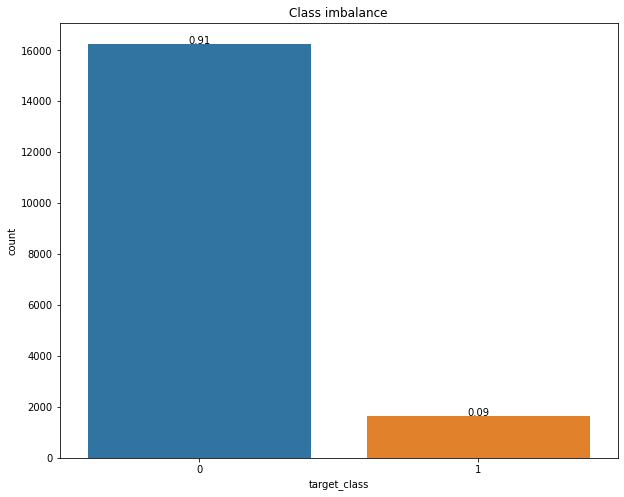

In [13]:
# Visualizing the distribution of Target Class
plt.figure(figsize = (10, 8))
plt.title("Class imbalance")
total = float(len(data))
ax = sns.countplot(x = 'target_class', data = data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}'.format(height/total),ha="center") 

In [7]:
# normalize the features by the mean and std of the training set
mXtrain = Xtrain.mean(axis=0)
sXtrain = Xtrain.std(axis=0)
Xtrain = (Xtrain-mXtrain)/sXtrain
Xtest = (Xtest-mXtrain)/sXtrain

### Data analysis : Dimensionality reduction and PCA

In order to display in 2-D or 3-D the data, dimensionality is needed. The simplest method is the principal component analysis, which perform an orthogonal linear projection on the principal axsis (eigenvector) of the covariance matrix.

First of all, here is the normalized covariance matrix of the training set :

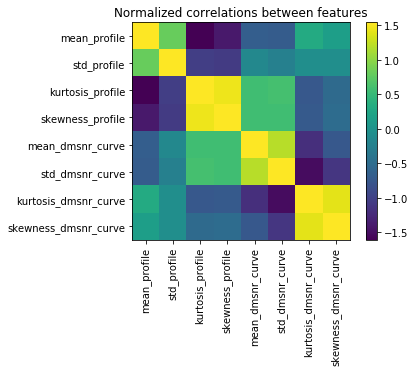

In [8]:
C = Xtrain.transpose().dot(Xtrain)
NC = (C - np.mean(C)) / np.std(C)
labels = ['mean_profile', 'std_profile', 'kurtosis_profile', 'skewness_profile',
          'mean_dmsnr_curve', 'std_dmsnr_curve', 'kurtosis_dmsnr_curve',
          'skewness_dmsnr_curve','target_class'] #rename to get shorter names
plt.xticks(np.arange(d), labels)
plt.xticks(rotation=90)
plt.yticks(np.arange(d), labels)
plt.title("Normalized correlations between features")
im = plt.imshow(NC)
plt.colorbar(im);

In the following, we compute the PCA ortho-basis and the features in the PCA basis :

In [9]:
U, s, V = np.linalg.svd(Xtrain) # SVD decomposition of the matrix of the data
Xtrainr = Xtrain.dot( V.transpose() ) # features in the PCA basis

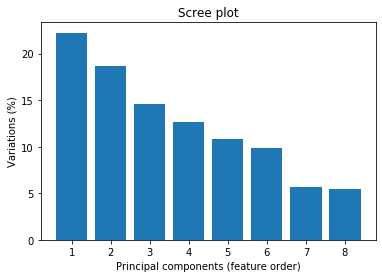

In [10]:
ex_variance = np.var(Xtrainr,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)

# scree plot (variation of regular sqrt(eigenvalues) plot)
plt.bar(np.arange(1,len(s)+1), np.sqrt(s)*100/sum(np.sqrt(s)))
plt.title("Scree plot")
plt.xlabel("Principal components (feature order)")
plt.ylabel('Variations (%)')
plt.ylim(bottom=0)
plt.show();

The first 2 (even 3) eigen vectors are carrying most of the information. We are not surprised to find this result as the first 4 features are informations extracted from the same source : the integrated pulse profile. We will surely lose some by reducing dimensions from 8 to 2/3 but we will be able to visualize the data. 

Now, we display the feature pair plots (I could have coded entirely myself but in my opinion, it has a limited interest)

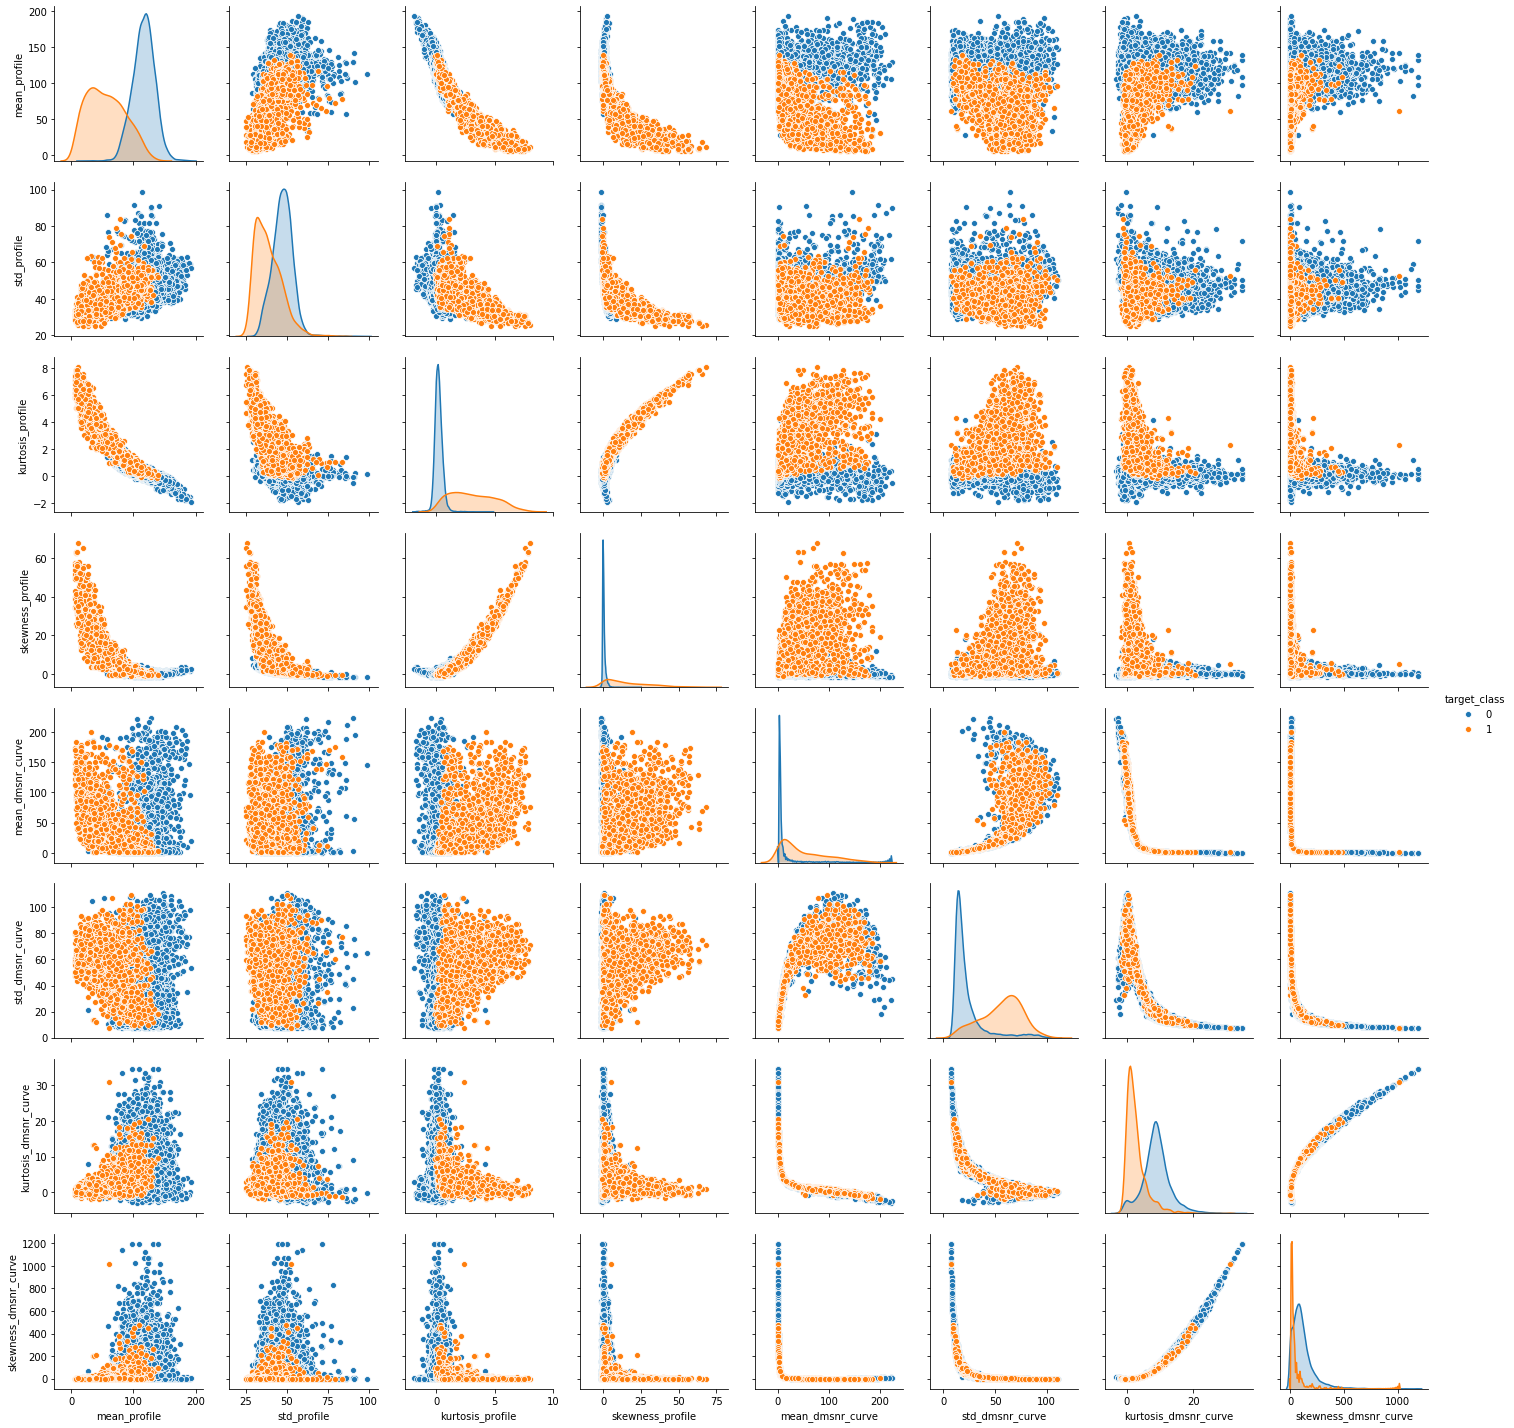

In [11]:
data.columns = ['mean_profile', 'std_profile', 'kurtosis_profile', 'skewness_profile',
                'mean_dmsnr_curve', 'std_dmsnr_curve', 'kurtosis_dmsnr_curve',
                'skewness_dmsnr_curve','target_class']
g = sns.pairplot(data, vars=['mean_profile', 'std_profile', 'kurtosis_profile', 'skewness_profile',
                'mean_dmsnr_curve', 'std_dmsnr_curve', 'kurtosis_dmsnr_curve',
                'skewness_dmsnr_curve'], hue="target_class")
plt.show()

On the diagonal, histograms show that features like skewness_profile has very little role to play in discerning pulsar from noise. Otherwise, features like mean_profile show a good separation between the 2 classes.
Outside the diagonal, we can see 2-by-2 feature correlation plots. Some features are highly correlated.

Now, let's apply PCA : it is essentially a method that reduces the dimension of the feature space in such a way that new variables are orthogonal to each other (i.e. they are independent or not correlated). 

Next, we plot PCA on the first 2/3 components as the variations for PC1/2/3 are high compared to the other. It might be still be noisy though. 

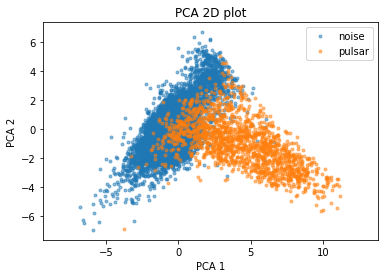

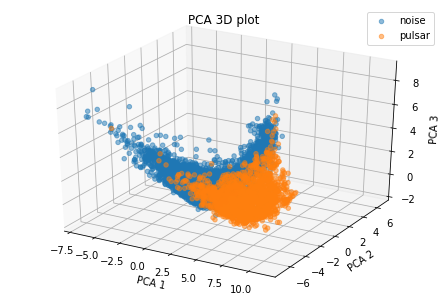

In [12]:
I0 = find(Ytrain==0) 
I1 = find(Ytrain==1)
Xr0 = Xtrainr[I0]
Xr1 = Xtrainr[I1]

fig = plt.figure()
plt.plot(Xr0[:,0], Xr0[:,1], '.', alpha=0.5, label="noise")
plt.plot(Xr1[:,0], Xr1[:,1], '.', alpha=0.5, label="pulsar")
plt.axis('equal')
plt.title("PCA 2D plot")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show();

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xr0[:,0], Xr0[:,1], Xr0[:,2], 'r', alpha=0.5, label="noise")
ax.scatter(Xr1[:,0], Xr1[:,1], Xr1[:,2], 'g', alpha=0.5, label="pulsar")
plt.title("PCA 3D plot")
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.legend()
plt.show();

As we can see, data is not perfectly separable when projected on the first 2 or 3 principal components. We can distinguish easily 2 distinct clusters though. 

Next and final analysis focuses on each feature independently :

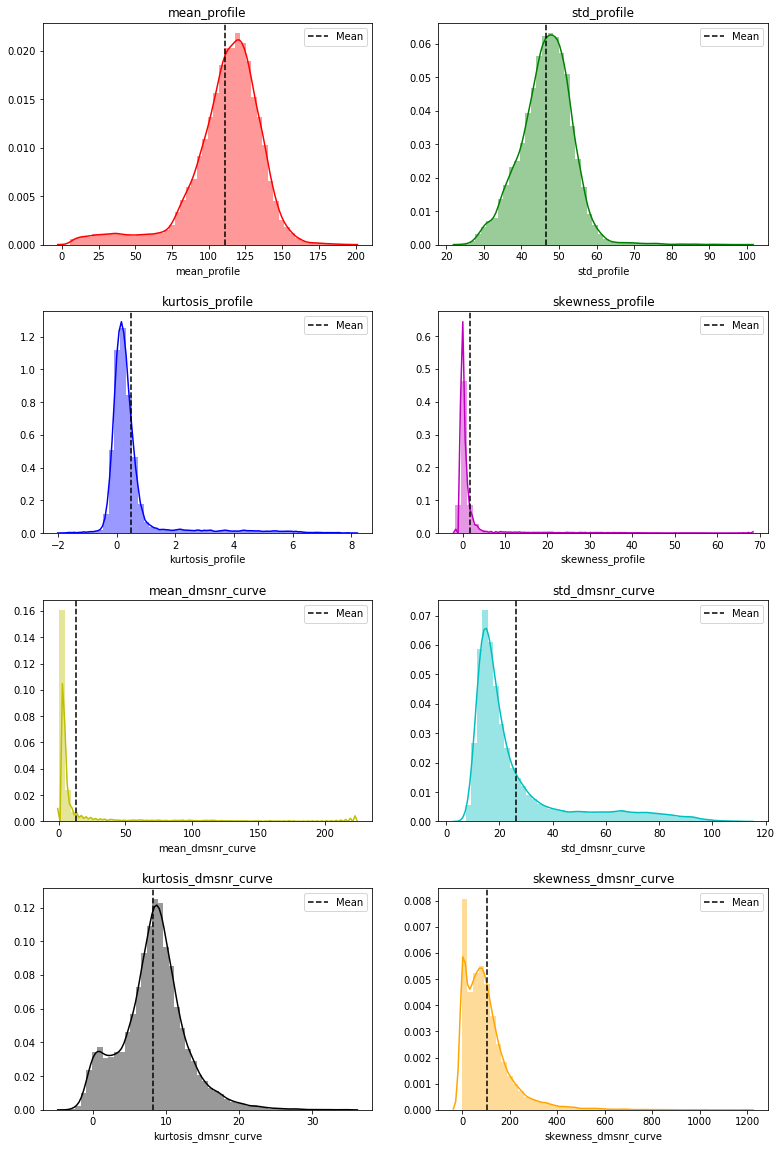

In [13]:
# plot the distribution of each features of the dataset
columns = [data.columns[i] for i in range(0,8)]
length  = len(columns)
colors  = ["r","g","b","m","y","c","k","orange"] 

plt.figure(figsize=(13,20))
for i,j,k in itertools.zip_longest(columns,range(length),colors):
    plt.subplot(length/2,length/4,j+1)
    sns.distplot(data[i],color=k)
    plt.title(i)
    plt.subplots_adjust(hspace = .3)
    plt.axvline(data[i].mean(),color = "k",linestyle="dashed",label="Mean")
    plt.legend(loc="upper right")

# 1 - Supervised ML

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, IsolationForest, StackingClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from xgboost import XGBClassifier

In [15]:
y = data['target_class']
x = data.copy().drop(['target_class'], axis = 1)

In [16]:
x

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306
...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910


In [17]:
y

0        0
1        0
2        0
3        0
4        0
        ..
17893    0
17894    0
17895    0
17896    0
17897    0
Name: target_class, Length: 17898, dtype: int64

### Splitting into training, validation and test sets

In [18]:
x_train, x_test1, y_train, y_test1 = train_test_split(x, y, test_size=0.40, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.50, random_state=42)

In [22]:
print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Test set shape:", x_test.shape)
print("-"*50)
print("Training target class shape:", y_train.shape)
print("Validation target class shape:", y_val.shape)
print("Test target class shape:", y_test.shape)

Training set shape: (10738, 8)
Validation set shape: (3580, 8)
Test set shape: (3580, 8)
--------------------------------------------------
Training target class shape: (10738,)
Validation target class shape: (3580,)
Test target class shape: (3580,)


### Model training

#### Logistic Regression

In [31]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9768156424581006
[[3224   24]
 [  59  273]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3248
           1       0.92      0.82      0.87       332

    accuracy                           0.98      3580
   macro avg       0.95      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580



/Users/louismonier/miniconda3/envs/work/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Grid search for hyper-parameters

In [32]:
param_grid = [    
    {'penalty' : ['l1'],
     'tol' : np.logspace(-8, 0, 10),
     'C' : np.logspace(-4, 4, 10),
     'fit_intercept' : ['True', 'False'],
     'class_weight' : [None, 'balanced'],
     'solver' : ['liblinear', 'saga'],
     'max_iter' : np.logspace(1, 4, 4)
    },
    {'penalty' : ['elasticnet'],
     'tol' : np.logspace(-8, 0, 10),
     'C' : np.logspace(-4, 4, 10),
     'fit_intercept' : ['True', 'False'],
     'class_weight' : [None, 'balanced'],
     'solver' : ['saga'],
     'max_iter' : np.logspace(1, 4, 4)
    },
    {'penalty' : ['l2', 'none'],
     'tol' : np.logspace(-8, 0, 10),
     'C' : np.logspace(-4, 4, 10),
     'fit_intercept' : ['True', 'False'],
     'class_weight' : [None, 'balanced'],
     'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'max_iter' : np.logspace(1, 4, 4)
    }
]

In [33]:
clf_grid = GridSearchCV(model, param_grid= param_grid, cv = 5, verbose=True, n_jobs=-1)

In [34]:
best_clf_grid = clf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 17600 candidates, totalling 88000 fits


KeyboardInterrupt: 

In [35]:
est = LogisticRegression(C=0.3593813663804626, class_weight=None, dual=False,
                   fit_intercept='True', intercept_scaling=1, l1_ratio=None,
                   max_iter=10.0, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear',
                   tol=5.994842503189409e-07, verbose=0, warm_start=False)

In [36]:
est.fit(x_train, y_train)
y_pred = est.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9768156424581006
[[3224   24]
 [  59  273]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3248
           1       0.92      0.82      0.87       332

    accuracy                           0.98      3580
   macro avg       0.95      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580



/Users/louismonier/miniconda3/envs/work/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


#### AdaBoost Classifier

In [37]:
est = LogisticRegression()
model = AdaBoostClassifier(base_estimator=est)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

/Users/louismonier/miniconda3/envs/work/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/louismonier/miniconda3/envs/work/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

0.9715083798882681
[[3228   20]
 [  82  250]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3248
           1       0.93      0.75      0.83       332

    accuracy                           0.97      3580
   macro avg       0.95      0.87      0.91      3580
weighted avg       0.97      0.97      0.97      3580



#### Decision Tree Classifier

In [38]:
est = DecisionTreeClassifier()
model = AdaBoostClassifier(base_estimator=est)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9681564245810056
[[3188   60]
 [  54  278]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3248
           1       0.82      0.84      0.83       332

    accuracy                           0.97      3580
   macro avg       0.90      0.91      0.91      3580
weighted avg       0.97      0.97      0.97      3580



#### Random Forest Classifier

In [39]:
est = RandomForestClassifier()
model = AdaBoostClassifier(base_estimator=est)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9776536312849162
[[3226   22]
 [  58  274]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3248
           1       0.93      0.83      0.87       332

    accuracy                           0.98      3580
   macro avg       0.95      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580



#### MLP Classifier

In [40]:
model = MLPClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9751396648044692
[[3220   28]
 [  61  271]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3248
           1       0.91      0.82      0.86       332

    accuracy                           0.98      3580
   macro avg       0.94      0.90      0.92      3580
weighted avg       0.97      0.98      0.97      3580



#### XGBoost Classifier

In [41]:
XGBClassifier(nthread=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.9756983240223464
[[3220   28]
 [  59  273]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3248
           1       0.91      0.82      0.86       332

    accuracy                           0.98      3580
   macro avg       0.94      0.91      0.92      3580
weighted avg       0.98      0.98      0.98      3580



# Annexe :

Here are more details about the features of the dataset of this study :

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes.

Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation . Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.

The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR curve.